In [1]:
#necessary imports
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "notebook_connected"

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# Part 1 : Exploratory Data Analysis

In [34]:
df_uber = pd.concat([pd.read_csv(f'data/uber-raw-data-{month}.csv') for month in ('apr14', 'may14', 'jun14', 'jul14', 'aug14', 'sep14')])
df_uber.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [35]:
df_zones = pd.read_csv('data/taxi-zone-lookup.csv')
df_zones.head()

,LocationID,Borough,Zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights


In [36]:
#preprocessing
df_uber['Date/Time'] = pd.to_datetime(df_uber['Date/Time'])
df_uber['Day'] = df_uber['Date/Time'].dt.day
df_uber['Hour'] = df_uber['Date/Time'].dt.hour
df_uber['Month'] = df_uber['Date/Time'].dt.month
df_uber['dayofweek'] = df_uber['Date/Time'].dt.dayofweek

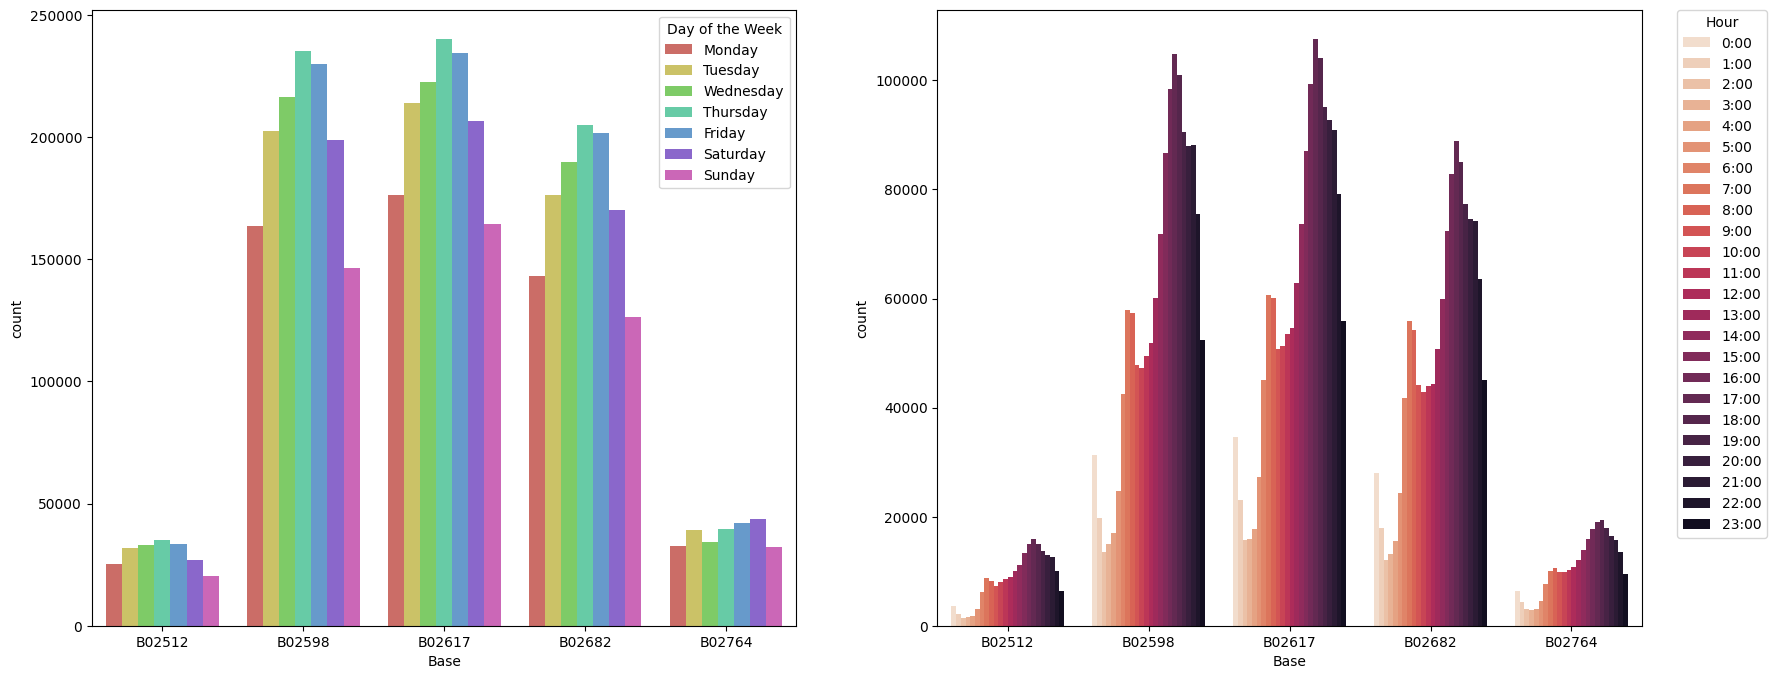

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
sns.countplot(data=df_uber,x='Base',hue='dayofweek', ax=ax1, palette='hls')
ax1.legend(title='Day of the Week', labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.countplot(data=df_uber,x='Base',hue='Hour', ax=ax2, palette=sns.color_palette('rocket_r', 24))
ax2.legend(title='Hour', labels=[f'{i}:00' for i in range(24)], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
